In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import numpy as np

img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    "defungi",                  # path to dataset
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_data = datagen.flow_from_directory(
    "defungi",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 7295 images belonging to 5 classes.
Found 1819 images belonging to 5 classes.


In [7]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))

# Add Global Average Pooling to flatten feature maps
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
feature_model = Model(inputs=base_model.input, outputs=x)

# Freeze base VGG16 weights
for layer in base_model.layers:
    layer.trainable = False

feature_model.summary()  # optional: shows model architecture


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
# Extract features from images
train_features = feature_model.predict(train_data, verbose=1)
val_features = feature_model.predict(val_data, verbose=1)

# Store labels
y_train = train_data.classes
y_val = val_data.classes
class_names = list(train_data.class_indices.keys())

print("✅ Train features shape:", train_features.shape)
print("✅ Validation features shape:", val_features.shape)
print("✅ Classes:", class_names)


c:\Users\sahit\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


228/228 ━━━━━━━━━━━━━━━━━━━━ 1171s 5s/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 333s 6s/step
✅ Train features shape: (7295, 512)
✅ Validation features shape: (1819, 512)
✅ Classes: ['H1', 'H2', 'H3', 'H5', 'H6']


In [9]:
import numpy as np
import pandas as pd

# Flatten features
train_features_flat = train_features.reshape(train_features.shape[0], -1)
val_features_flat = val_features.reshape(val_features.shape[0], -1)

# Create DataFrames with labels and split column
train_df = pd.DataFrame(train_features_flat)
train_df['label'] = y_train
train_df['split'] = 'train'

val_df = pd.DataFrame(val_features_flat)
val_df['label'] = y_val
val_df['split'] = 'val'

# Concatenate train and validation
full_df = pd.concat([train_df, val_df], ignore_index=True)

# Save to a single CSV
full_df.to_csv("features_vgg16_full.csv", index=False)

print("✅ Combined features saved as 'features_vgg16_full.csv'")


✅ Combined features saved as 'features_vgg16_full.csv'


In [10]:
import numpy as np

# Summation
def summation(x, w):
    return np.dot(w, x)

# Activations
def step_activation(x):
    return 1.0 if x >= 0 else 0.0

def bipolar_step_activation(x):
    return 1.0 if x >= 0 else -1.0

def sigmoid_activation(x):
    return 1.0/(1.0 + np.exp(-x))

def relu_activation(x):
    return x if x > 0 else 0.0

# SSE
def sse(targets, outputs):
    return 0.5 * np.sum((targets - outputs)**2)


In [11]:
import numpy as np

# Training function
def train_perceptron(X, y, w_init, lr=0.05, activation='step', max_epochs=1000, tol=0.002):
    def summation(x, w): return np.dot(w, x)
    def step(x): return 1 if x>=0 else 0
    def bipolar(x): return 1 if x>=0 else -1
    def sigmoid(x): return 1/(1+np.exp(-x))
    def relu(x): return x if x>0 else 0
    def sse(t,o): return 0.5*np.sum((t-o)**2)

    N,d = X.shape
    Xb = np.hstack([np.ones((N,1)), X])
    w = w_init.copy()
    sse_hist=[]
    for epoch in range(1,max_epochs+1):
        outputs=[]
        for i in range(N):
            net = summation(Xb[i], w)
            if activation=='step':
                out = step(net); error = y[i]-out; w += lr*error*Xb[i]
            elif activation=='bipolar':
                out = bipolar(net); yi = 1 if y[i]==1 else -1; error = yi-out; w += lr*error*Xb[i]
            elif activation=='sigmoid':
                out = sigmoid(net); error = y[i]-out; w += lr*error*out*(1-out)*Xb[i]
            elif activation=='relu':
                out = relu(net); error = y[i]-out; grad = 1 if net>0 else 0; w += lr*error*grad*Xb[i]
            outputs.append(out)
        mapped = (np.array(outputs)+1)/2 if activation=='bipolar' else np.array(outputs)
        curr = sse(y,mapped); sse_hist.append(curr)
        if curr<=tol: return w,sse_hist,epoch,True
    return w,sse_hist,epoch,False

# AND dataset
X_and = np.array([[0,0],[0,1],[1,0],[1,1]])
y_and = np.array([0,0,0,1])
w_init = np.array([10.0,0.2,-0.75])

# Try different activations
for act in ['step','bipolar','sigmoid','relu']:
    w,hist,ep,conv = train_perceptron(X_and,y_and,w_init,lr=0.05,activation=act)
    print(act, "epochs:",ep,"converged:",conv,"final weights:",w)


step epochs: 130 converged: True final weights: [-0.1   0.1   0.05]
bipolar epochs: 68 converged: True final weights: [-0.3   0.2   0.15]
sigmoid epochs: 1000 converged: False final weights: [ 9.99101457  0.1981319  -0.75483714]
relu epochs: 1000 converged: False final weights: [ 2.67803548e-22 -2.32873270e+00 -2.87256355e+00]


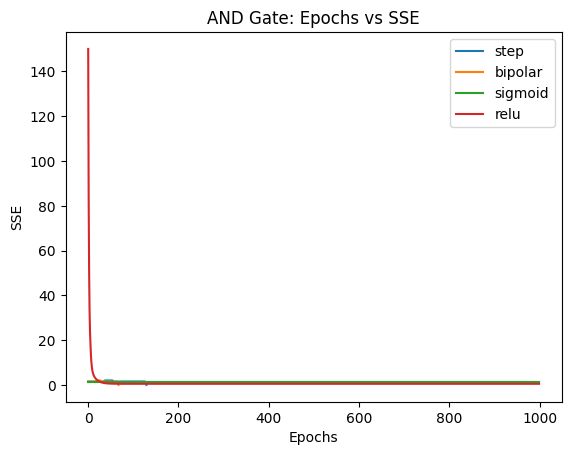

In [12]:
import matplotlib.pyplot as plt

# Using results from Q2
for act in ['step','bipolar','sigmoid','relu']:
    _, hist, _, _ = train_perceptron(X_and,y_and,w_init,lr=0.05,activation=act)
    plt.plot(hist,label=act)

plt.xlabel("Epochs")
plt.ylabel("SSE")
plt.title("AND Gate: Epochs vs SSE")
plt.legend()
plt.show()


    lr  epochs  converged
0  0.1      68       True
1  0.2      37       True
2  0.3      23       True
3  0.4      23       True
4  0.5      19       True
5  0.6      19       True
6  0.7      15       True
7  0.8      14       True
8  0.9      13       True
9  1.0      12       True


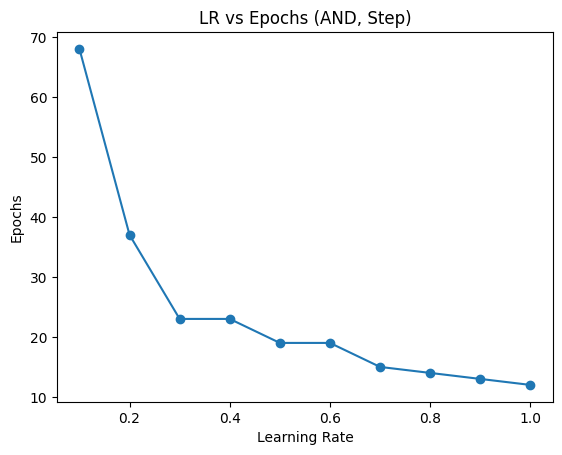

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

lrs = [0.1*i for i in range(1,11)]
records=[]
for lr in lrs:
    _,_,ep,conv = train_perceptron(X_and,y_and,w_init,lr=lr,activation='step')
    records.append({'lr':lr,'epochs':ep,'converged':conv})

df_lr = pd.DataFrame(records)
print(df_lr)

plt.plot(df_lr['lr'], df_lr['epochs'], marker='o')
plt.xlabel("Learning Rate")
plt.ylabel("Epochs")
plt.title("LR vs Epochs (AND, Step)")
plt.show()


XOR attempt: epochs: 1000 converged: False


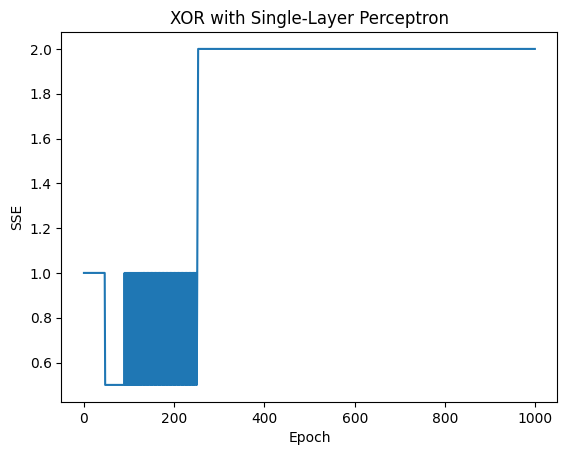

In [14]:
X_xor = X_and.copy()
y_xor = np.array([0,1,1,0])

_, hist, ep, conv = train_perceptron(X_xor,y_xor,w_init,lr=0.05,activation='step')
print("XOR attempt:", "epochs:",ep,"converged:",conv)

plt.plot(hist)
plt.xlabel("Epoch")
plt.ylabel("SSE")
plt.title("XOR with Single-Layer Perceptron")
plt.show()


Final weights: [1.53331052 0.02911212 3.62046548 0.28416814 4.11475807] Epochs: 7718


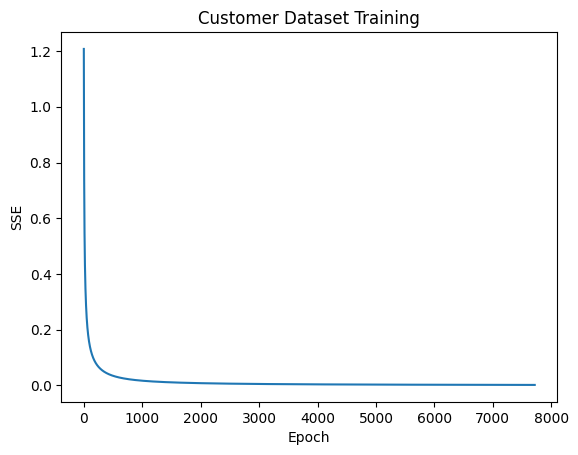

In [15]:
cust_data = {
    'Customer':[f"C_{i}" for i in range(1,11)],
    'Candies':[20,16,27,19,24,22,15,18,21,16],
    'Mangoes':[6,3,6,1,4,1,4,4,1,2],
    'MilkPackets':[2,6,2,2,2,5,2,2,4,4],
    'Payment':[386,289,393,110,280,167,271,274,148,198],
    'HighValue':[1,1,1,0,1,0,1,1,0,0]
}
df = pd.DataFrame(cust_data)
df.to_csv("data.csv",index=False)

X = df[['Candies','Mangoes','MilkPackets','Payment']].values.astype(float)
y = df['HighValue'].values.astype(float)

Xn = (X-X.mean(0))/X.std(0)
Xb = np.hstack([np.ones((Xn.shape[0],1)),Xn])
w = np.zeros(Xb.shape[1])

hist=[]
for epoch in range(10000):
    outs=[]
    for i in range(Xb.shape[0]):
        net = np.dot(w,Xb[i])
        out = 1/(1+np.exp(-net))
        error = y[i]-out
        w += 0.05*error*out*(1-out)*Xb[i]
        outs.append(out)
    curr = 0.5*np.sum((y-np.array(outs))**2)
    hist.append(curr)
    if curr<=0.002: break

print("Final weights:", w, "Epochs:", epoch)
plt.plot(hist); plt.xlabel("Epoch"); plt.ylabel("SSE"); plt.title("Customer Dataset Training"); plt.show()


In [16]:
wp = np.linalg.pinv(Xb).dot(y)
yp = (Xb.dot(wp)>=0.5).astype(int)

print("Pseudo-inverse weights:", wp)
print("Predicted labels:", yp)


Pseudo-inverse weights: [ 0.6        -0.09436819  0.21713405 -0.01342766  0.23416864]
Predicted labels: [1 1 1 0 1 0 1 1 0 0]


In [17]:
# and_backprop.py
import numpy as np

# reproducible results
np.random.seed(42)

# Sigmoid and derivative
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def dsigmoid(y):
    # derivative in terms of output y = sigmoid(x)
    return y * (1.0 - y)

# Network architecture: 2 inputs, 2 hidden neurons, 1 output
n_input = 2
n_hidden = 2
n_output = 1

# Learning rate
alpha = 0.05

# Training data: AND gate
X = np.array([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0]
])
T = np.array([[0.0], [0.0], [0.0], [1.0]])  # targets (column vector)

# Initialize weights small random values (bias included)
# We'll represent weights matrices with bias as first column: W_hidden shape (n_hidden, n_input+1)
W_hidden = np.random.uniform(-1.0, 1.0, size=(n_hidden, n_input + 1)) * 0.5
# W_output shape (n_output, n_hidden+1)
W_output = np.random.uniform(-1.0, 1.0, size=(n_output, n_hidden + 1)) * 0.5

# Training hyperparams
max_epochs = 10000
tol = 1e-3  # target MSE threshold

def forward(x):
    """
    Forward pass for one sample x (length n_input).
    Returns: hidden_outputs (length n_hidden), final_output (length n_output)
    """
    # add bias term to input
    x_b = np.concatenate(([1.0], x))  # bias=1 at index0
    # hidden net input
    net_h = W_hidden.dot(x_b)  # shape (n_hidden,)
    out_h = sigmoid(net_h)     # shape (n_hidden,)
    # add bias to hidden outputs
    h_b = np.concatenate(([1.0], out_h))  # shape (n_hidden+1,)
    net_o = W_output.dot(h_b)  # shape (n_output,)
    out_o = sigmoid(net_o)     # shape (n_output,)
    return x_b, out_h, h_b, out_o

def train():
    global W_hidden, W_output
    for epoch in range(1, max_epochs + 1):
        mse_epoch = 0.0
        # stochastic (online) - iterate samples in order
        for i in range(X.shape[0]):
            x = X[i]
            t = T[i]  # shape (1,)

            # forward pass
            x_b, out_h, h_b, out_o = forward(x)  # out_o shape (1,)

            # compute error and MSE contribution
            err = t - out_o  # shape (1,)
            mse_epoch += 0.5 * np.sum(err ** 2)

            # backward pass (output layer)
            delta_o = err * dsigmoid(out_o)  # shape (1,)

            # update output weights: W_output += alpha * delta_o * h_b (h_b is vector); W_output shape (1, n_hidden+1)
            # use outer product to update
            W_output += alpha * np.outer(delta_o, h_b)

            # hidden layer deltas (exclude bias weight from W_output when propagating)
            # W_output[:,1:] shape (1, n_hidden)
            delta_h = dsigmoid(out_h) * (W_output[:, 1:].T.dot(delta_o)).flatten()  # shape (n_hidden,)

            # update hidden weights: W_hidden += alpha * delta_h[:,None] * x_b[None,:]
            W_hidden += alpha * (delta_h.reshape(-1,1) @ x_b.reshape(1,-1))

        mse_epoch /= X.shape[0]  # average MSE over samples
        if epoch % 100 == 0 or mse_epoch <= tol:
            print(f"Epoch {epoch:5d}  MSE={mse_epoch:.6f}")
        if mse_epoch <= tol:
            print("Training converged.")
            break
    else:
        print("Reached max epochs without reaching target MSE.")
    return epoch, mse_epoch

def test_and_print():
    print("\nFinal weights (hidden layer, bias first):")
    print(W_hidden)
    print("\nFinal weights (output layer, bias first):")
    print(W_output)
    print("\nNetwork outputs on AND inputs:")
    for i in range(X.shape[0]):
        x = X[i]
        _, out_h, _, out_o = forward(x)
        print(f" Input: {x.tolist():}  -> Output: {out_o[0]:.6f}  (target {T[i,0]:.0f})")

if __name__ == "__main__":
    print("Initial W_hidden:\n", W_hidden)
    print("Initial W_output:\n", W_output)
    epoch, final_mse = train()
    test_and_print()


Initial W_hidden:
 [[-0.12545988  0.45071431  0.23199394]
 [ 0.09865848 -0.34398136 -0.34400548]]
Initial W_output:
 [[-0.44191639  0.36617615  0.10111501]]
Epoch   100  MSE=0.093395
Epoch   200  MSE=0.091688
Epoch   300  MSE=0.090583
Epoch   400  MSE=0.089286
Epoch   500  MSE=0.087673
Epoch   600  MSE=0.085688
Epoch   700  MSE=0.083300
Epoch   800  MSE=0.080503
Epoch   900  MSE=0.077315
Epoch  1000  MSE=0.073774
Epoch  1100  MSE=0.069933
Epoch  1200  MSE=0.065851
Epoch  1300  MSE=0.061592
Epoch  1400  MSE=0.057223
Epoch  1500  MSE=0.052809
Epoch  1600  MSE=0.048419
Epoch  1700  MSE=0.044121
Epoch  1800  MSE=0.039982
Epoch  1900  MSE=0.036061
Epoch  2000  MSE=0.032405
Epoch  2100  MSE=0.029048
Epoch  2200  MSE=0.026004
Epoch  2300  MSE=0.023276
Epoch  2400  MSE=0.020853
Epoch  2500  MSE=0.018714
Epoch  2600  MSE=0.016835
Epoch  2700  MSE=0.015188
Epoch  2800  MSE=0.013747
Epoch  2900  MSE=0.012485
Epoch  3000  MSE=0.011379
Epoch  3100  MSE=0.010408
Epoch  3200  MSE=0.009553
Epoch  3300